# Feature Selection

Let's check out the performance of several tactics of feature selection.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph
from IPython.display import display, Markdown
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_selection import RFECV, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression

sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [2]:
# Get and preprocess data
x, y = load_breast_cancer().data, load_breast_cancer().target
x_std = StandardScaler().fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1992)

print('All', x.shape)
print('Train', x_train.shape)
print('Test', x_test.shape)

All (569, 30)
Train (398, 30)
Test (171, 30)


# Select By Simple Statistical Tests (*X* <sup>2</sup> and ANOVA)

----
 ## ANOVA

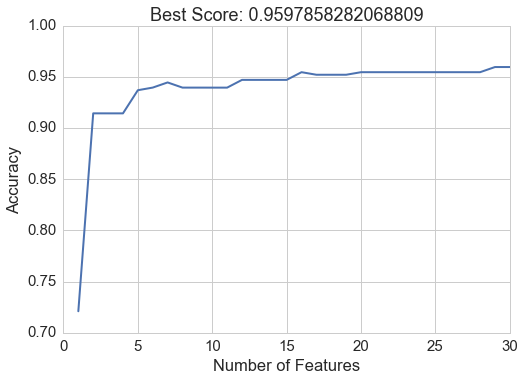

----
 ## *X* <sup>2</sup>

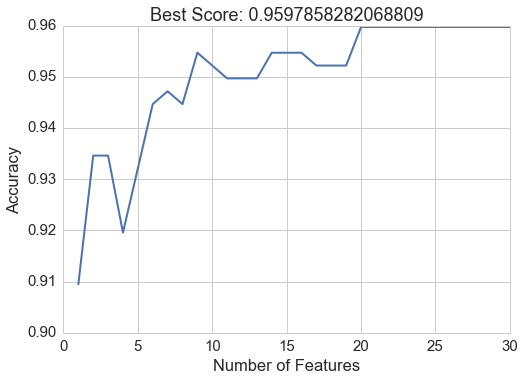

In [7]:
display(Markdown('# Select By Simple Statistical Tests (*X* <sup>2</sup> and ANOVA)'))

scorers = {'*X* <sup>2</sup>': chi2, 'ANOVA': f_classif}
logit = LogisticRegression()
validation_scores = pd.DataFrame(columns=['score', 'dimensions'])

for name, scorer in scorers.items():
    display(Markdown('----\n ## {}'.format(name)))
    
    # Loop through features and remember the best output
    for i in range(x.shape[1]):
        k = i+1
        i_x_train = x_train
        i_x_test = x_test
        
        # Select by Stratified K-Folding
        #strat_k_folding = StratifiedKFold(y_train, 5)
        #for train_indices, test_indices in strat_k_folding:
            # TODO do Cross Validated Predictions
        selector = SelectKBest(score_func=scorer, k=k)
        selector.fit(x_train, y_train)
        x_selected_train = selector.transform(i_x_train)
        x_selected_test = selector.transform(i_x_test)
        
        # Test
        logit = LogisticRegression()
        
        # Save Score
        validation_scores.loc[k] = [
            cross_val_score(logit, x_selected_train, y_train).mean(), x_selected_train.shape[1]
        ]
        
    # Graph Results
    graph.title('Best Score: {}'.format(
            validation_scores['score'].max()
        ))
    graph.plot(validation_scores['score'], linewidth=2.0)
    graph.ylabel('Accuracy')
    graph.xlabel('Number of Features')
    graph.show()

# Recursive Feature Elimination with Cross Validation

Optimal Number of Features: **23**

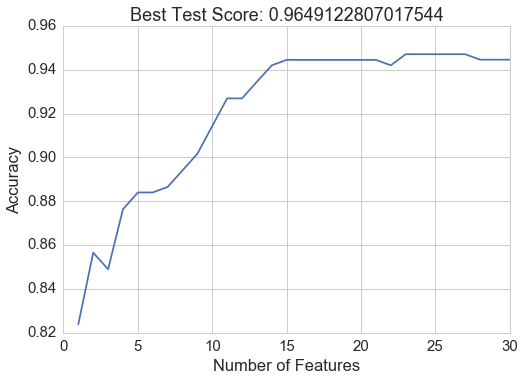

In [5]:
display(Markdown('# Recursive Feature Elimination with Cross Validation'))

logit = LogisticRegression()
rf_x_train = x_train

rfe = RFECV(estimator=logit, cv=StratifiedKFold(y_train, 5), scoring='accuracy')  # Using Accuracy just like the last one
rfe.fit(rf_x_train, y_train)

display(Markdown(('Optimal Number of Features: **{}**'.format(rfe.n_features_))))

# Graph Results
rf_x_train, rf_x_test = rfe.transform(x_train), rfe.transform(x_test)
logit.fit(rf_x_train, y_train)

graph.title('Best Test Score: {}'.format(logit.score(rf_x_test, y_test)))
graph.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
graph.xlabel('Number of Features')
graph.ylabel('Accuracy')
graph.show()